In [1]:
import numpy as np
from deep_learning_models import *
from helper.dataset_reader import read_tsv
from helper.utils import *
import pandas as pd

In [2]:
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.8.0
GPU detected: []


In [3]:
merged_data = read_tsv('../../dataset/comlid-data-140422-v1.tsv')

train_data = read_tsv('../../dataset/train.tsv')
val_data = read_tsv('../../dataset/val.tsv')
test_data = read_tsv('../../dataset/test.tsv')

In [4]:
X_word_tr, X_char_tr, y_tr, idx_word_tr, idx_tag_tr = wc_input_converter(merged_data, train_data)
X_word_val, X_char_val, y_val, idx_word_val, idx_tag_val = wc_input_converter(merged_data, val_data)
X_word_ts, X_char_ts, y_ts, idx_word_ts, idx_tag_ts = wc_input_converter(merged_data, test_data)

In [5]:
df = list_to_dataframe(merged_data)

In [6]:
words = get_unique_words(df)
tags = get_unique_tags(df)
chars = set([w_i for w in words for w_i in w])

In [7]:
num_words = len(words)
num_tags = len(tags)
num_char = len(chars)
max_len = 100
max_len_char = 10
model = wc_blstm_model(num_words, num_tags, num_char, max_len, max_len_char)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 10)]    0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (None, 100, 10, 10)  5570       ['input_2[0][0]']                
 ted)                                                                                             
                                                                                                  
 embedding (Embedding)          (None, 100, 50)      1344600     ['input_1[0][0]']            

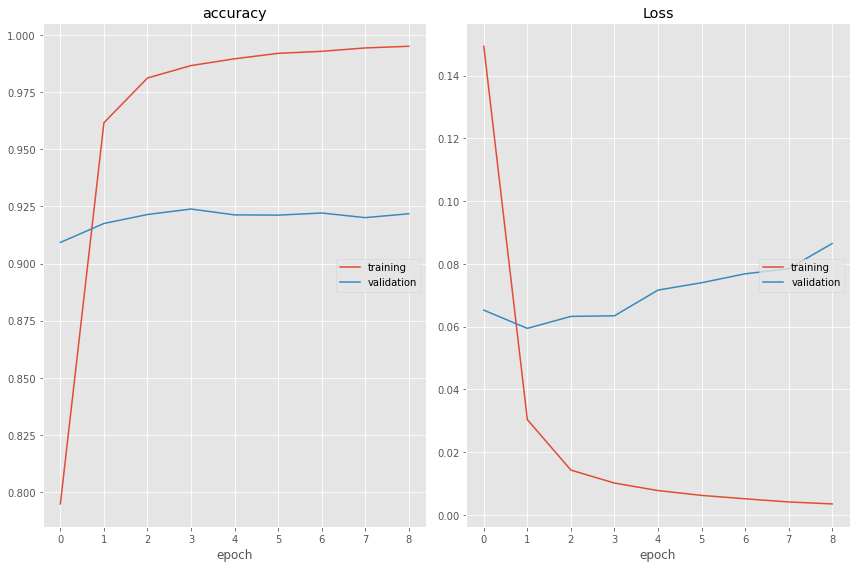

accuracy
	training         	 (min:    0.795, max:    0.995, cur:    0.995)
	validation       	 (min:    0.909, max:    0.924, cur:    0.922)
Loss
	training         	 (min:    0.004, max:    0.149, cur:    0.004)
	validation       	 (min:    0.059, max:    0.086, cur:    0.086)

Epoch 9: val_loss did not improve from 0.05945
56/56 [==============================] - 4s 63ms/step - loss: 0.0806 - accuracy: 0.9228
[0.08062365651130676, 0.9227529168128967]


In [8]:
root_path = 'model/'
model_name = 'wc_blstm_model_v2.h5'
num_epoch = 50
batch_sz = 32
callbacks = get_callbacks(root_path, model_name)

history = model.fit(x=[X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    y=np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    #validation_data=(X_word_val, y_val),
                    validation_data=(
                      [X_word_val, np.array(X_char_val).reshape((len(X_char_val),
                                                                max_len, max_len_char))],
                        np.array(y_val).reshape(len(y_val), max_len, 1)
                    ),
                    batch_size=batch_sz,
                    epochs=num_epoch,
                    callbacks=callbacks,
                    verbose=1
                    )

print(model.evaluate([X_word_ts, np.array(X_char_ts).reshape((len(X_char_ts), max_len, max_len_char))], np.array(y_ts).reshape(len(y_ts), max_len, 1)))

In [9]:
from keras.models import load_model

mdl = load_model('model/wc_blstm_model_v2.h5')

In [10]:
predict_val = [X_word_ts, np.array(X_char_ts).reshape((len(X_char_ts), max_len, max_len_char))]

i = np.random.randint(0, X_word_ts.shape[0])
p = mdl.predict(predict_val)

p = np.argmax(p[i], axis=-1)
y_true = y_ts[i]
print("{:30}{:10}\t {}\n".format("Word", "True", "Pred"))
print("-" *60)

for w, true, pred in zip(X_word_ts[i], y_true, p):
    if w != 0:
        print("{:30}{:10}\t{}".format(idx_word_ts[w], idx_tag_ts[true], idx_tag_ts[pred]))

Word                          True      	 Pred

------------------------------------------------------------
Niate                         JV        	O
checkout                      EN        	O
tapi                          ID        	ID
ongkire                       MIX-ID-JV 	MIX-ID-JV
ra                            JV        	JV
dibayar                       JV        	ID
gen                           JV        	JV
ra                            JV        	JV
dikirim                       JV        	JV
jebul                         JV        	JV
gratis                        ID        	ID
ongkir                        ID        	ID
😩                             O         	O
https://t.co/RYHWCnhLTO       O         	O


In [11]:
all_w_pair = []
all_true_pair = []
all_pred_pair = []

for i in range(len(X_word_ts)):
    p = model.predict([X_word_ts,
                        np.array(X_char_ts).reshape((len(X_char_ts),
                                                     max_len, max_len_char))])
    p = np.argmax(p[i], axis=-1)
    y_true = y_ts[i]
    w_pair = []
    true_pair = []
    pred_pair = []
    for w, true, pred in zip(X_word_ts[i], y_true, p):
        if w != 0:
            # print("{:30}{:10}\t{}".format(idx_word[w], idx_tag[true], idx_tag[pred]))
            w_pair.append(idx_word_ts[w])
            true_pair.append(idx_tag_ts[true])
            pred_pair.append(idx_tag_ts[pred])
    all_w_pair.append(w_pair)
    all_true_pair.append(true_pair)
    all_pred_pair.append(pred_pair)

In [12]:
true_flat = [item for sublist in all_true_pair for item in sublist]
pred_flat = [item for sublist in all_pred_pair for item in sublist]

              precision    recall  f1-score   support

          ID     0.9288    0.9602    0.9443     22307
          JV     0.8532    0.8718    0.8624      4915
          EN     0.8826    0.8842    0.8834      5018
   MIX-ID-EN     0.9396    0.8479    0.8914       973
   MIX-ID-JV     0.8462    0.8643    0.8551       280
   MIX-JV-EN     0.9555    0.8520    0.9008       277
           O     0.9664    0.8948    0.9292     10154

    accuracy                         0.9228     43924
   macro avg     0.9103    0.8822    0.8952     43924
weighted avg     0.9236    0.9228    0.9227     43924



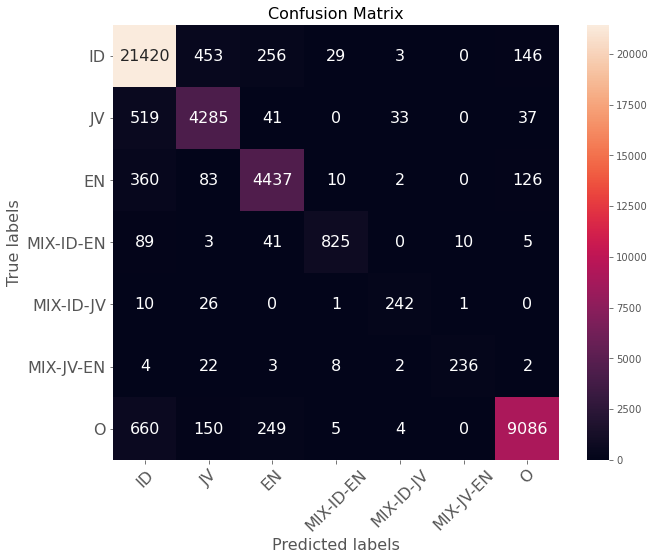

In [13]:
performance_report(true_flat, pred_flat)

In [14]:
df_ = pd.DataFrame({
    'word': all_w_pair,
    'true': all_true_pair,
    'pred': all_pred_pair
})

In [15]:
token_true_pred = []
for index, row in df_.iterrows():
    pair = list(zip(row['word'], row['true'], row['pred']))
    token_true_pred.append(pair)

In [16]:
true_pred_file = 'tagging_result/wc_blstm_compare_results.tsv'
with open(true_pred_file, "a", encoding='utf-8') as f:
    f.write("Word" + "\t" + "True" + "\t" + "Predict" + "\n")
    for index, row in df_.iterrows():
        for tkn, t_true, t_pred in (zip(row['word'], row['true'], row['pred'])):
            f.write(tkn + '\t' + t_true + '\t' + t_pred + '\n')
        f.write('\n')

f.close()

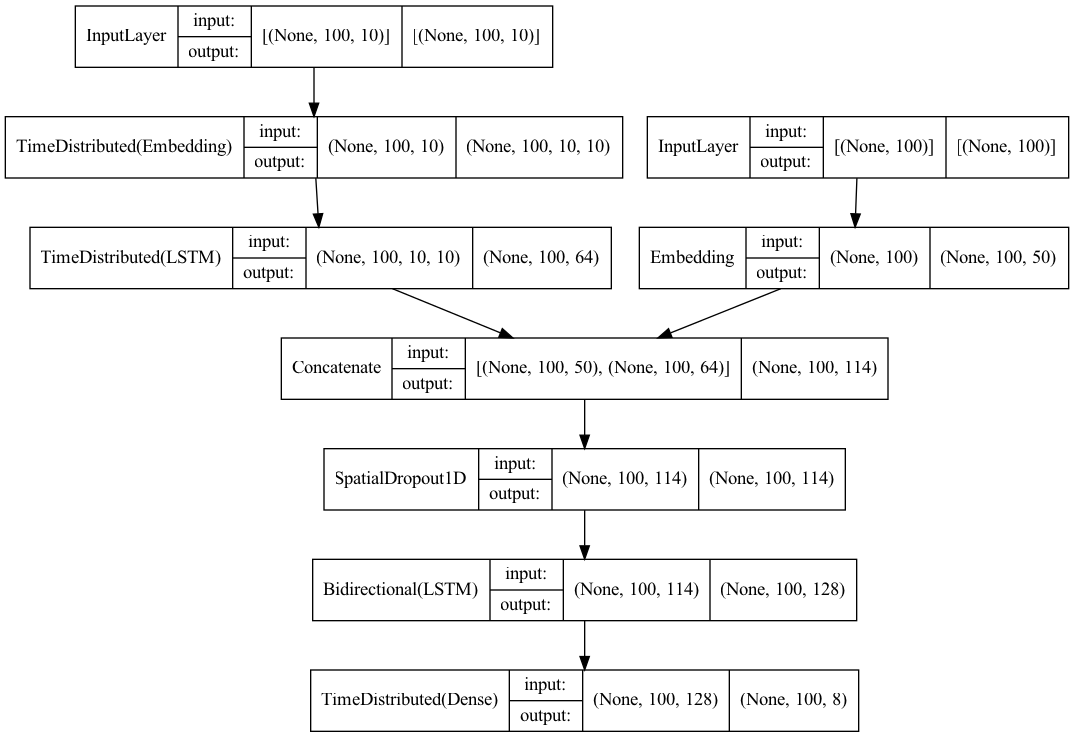

In [17]:
from keras.utils.vis_utils import plot_model
plot_model(mdl, to_file='model_plot/tr_wc_blstm_90.png', show_shapes=True, show_layer_names=False)